# 概要
### 分析の目的
- ECサイトにて中価格・高価格な商品のレコメンドタイミングを明らかにする

### 背景
- 初めて利用するECサイトでは「安心して購入できるサイトのか」という不安があると考え、購入回数が少ないうちは低価格な商品を購入すると考える
- そのため、購入回数が少ないうちは低価格な商品をレコメンドするほうが良いと考える
- しかし、低価格な商品だけを購入されても1回あたりの購入金額は増加しない
- そのため、どこかのタイミングで中価格・高価格な商品をレコメンドするようにしたい
- 複数回購入していれば、中価格・高価格商品を閲覧するようになり、購入するようになると考える
- しかし、何回目あたりから中価格・高価格なものを購入するかは不明である
- もし、中価格・高価格なものを購入するために必要な購入回数がわかれば、その回数から、中価格・高価格の商品をレコメンドすることで購入頻度・1回あたりの購入金額が増大する可能性があると考える
- そこで今回は、購入回数ごとに購入者はどのページにアクセスしたかを明らかにする

### 分析内容
- 購入の有無を目的変数・来訪したページの有無を説明変数として決定木を用いて分析をする
- 上記の分析を下記の対象のとおり分けて4回行う
  1. 全ユーザを対象
  2. 1のユーザを対象（1回購入したユーザが分析対象）
  3. 2のユーザを対象（2回購入したユーザが分析対象）
  4. 3のユーザを対象（3回購入したユーザが分析対象）

### 補足
- ECサイトのページは下記のとおり
  - 低価格_1：例) 文房具
  - 低価格_2：例) 日用品
  - 中価格_1：例) 洋服
  - 中価格_2：例) スポーツ・アウトドア
  - 高価格_1：例) 家電
  - 高価格_2：例) 家具


In [1]:
import numpy as np
import pandas as pd
import uuid

from numpy.random import *

In [2]:
def get_sumple_first(target_class_main, target_class_sub, p, Num_purchases):
    SAMPLE_SIZE=10000
    PRICE_CLASS=['低価格_1', '低価格_2', '中価格_1', '中価格_2', '高価格_1', '高価格_2']

    # 平均5, 標準偏差2の正規分布から値を一つ取り出してint型に変換（少数点以下切り捨て）
    visit_num = np.random.normal(5, 2, 1).astype(int)[0]

    lst_df=[]
    for i in range(0,SAMPLE_SIZE):
        # 1ユーザの行動を作成
        ## 来訪ページ数が平均3、標準偏差1の分布から1の値を取得
        _visit_num = np.random.normal(3, 1, 1)[0]
        ## 来訪ページ数を最大6に設定
        visit_num = np.clip(_visit_num, 1, 6).astype("int")
        # 来訪ページ名を取得
        result_lst=np.random.choice(PRICE_CLASS, visit_num ,p=p)
        result=pd.Series(result_lst, name='来訪ページ')
        ## 1ユーザあたりの行動をデータフレームに入れる
        df_result=result.to_frame()
        ## user_idを付与
        df_result['user_id']=str(uuid.uuid4())
        lst_df.append(df_result)

    df_base=pd.concat(lst_df, axis='index')
    df_drop_dupli=df_base.drop_duplicates()

    df_result=pd.concat([df_drop_dupli[['user_id']]
                        , pd.get_dummies(df_drop_dupli['来訪ページ'])
                        ],
                        axis='columns').groupby('user_id').sum()

    e_z=randn(SAMPLE_SIZE)
    z_mean=(30*df_result[f'{target_class_main}'] + 20*df_result[f'{target_class_sub}'] ).mean()

    # シグモイド関数を使ってtarget_class来訪ユーザがより購入しやすいようにする
    z_base=np.array(30*df_result[f'{target_class_main}'] + 20*df_result[f'{target_class_sub}']  -z_mean + 5*e_z)
    # シグモイド関数
    from scipy.special import expit
    # シグモイド関数を計算
    z_prob=expit(0.1*z_base)

    # 未購入 or 購入の変数(0は未購入、1は購入)
    Z=np.array([])

    for i in range(SAMPLE_SIZE):
        Z_i=np.random.choice(2 # 0 or 1のどちらかを取得するという意味
                            , size=1 # 1つの値だけ取得する
                            , p=[1-z_prob[i], z_prob[i]] # 購入する確率(1が入る確率)がz_prob[i]
                            )[0]
        Z=np.append(Z, Z_i).astype(int)


    df_result['result']=Z
    df_result['Num_purchases']=Num_purchases

    return df_result

In [3]:
def get_sumple_second_onwards(_df, target_class_main, target_class_sub, p, Num_purchases):
    
    lst_id_first_buyer=_df[_df['result']==1].index
    PRICE_CLASS=['低価格_1', '低価格_2', '中価格_1', '中価格_2', '高価格_1', '高価格_2']

    # 平均5, 標準偏差2の正規分布から値を一つ取り出してint型に変換（少数点以下切り捨て）
    visit_num = np.random.normal(5, 2, 1).astype(int)[0]

    lst_df=[]
    for id_first_buyer in lst_id_first_buyer:
        # 1ユーザの行動を作成
        ## 来訪ページ数が平均3、標準偏差1の分布から1の値を取得
        _visit_num = np.random.normal(3, 1, 1)[0]
        ## 来訪ページ数を最大6に設定
        visit_num = np.clip(_visit_num, 1, 6).astype("int")
        # 来訪ページ名を取得
        result_lst=np.random.choice(PRICE_CLASS, visit_num ,p=p)
        result=pd.Series(result_lst, name='来訪ページ')
        ## 1ユーザあたりの行動をデータフレームに入れる
        df_result=result.to_frame()
        ## user_idを付与
        df_result['user_id']=id_first_buyer
        lst_df.append(df_result)
    pd.concat(lst_df, axis='index')



    df_base=pd.concat(lst_df, axis='index')
    df_drop_dupli=df_base.drop_duplicates()

    df_result=pd.concat([df_drop_dupli[['user_id']]
                        , pd.get_dummies(df_drop_dupli['来訪ページ'])
                        ],
                        axis='columns').groupby('user_id').sum()

    e_z=randn(len(lst_id_first_buyer))
    z_mean=(30*df_result[f'{target_class_main}'] + 20*df_result[f'{target_class_sub}'] ).mean()

    # シグモイド関数を使ってtarget_class来訪ユーザがより購入しやすいようにする
    z_base=np.array(30*df_result[f'{target_class_main}'] + 20*df_result[f'{target_class_sub}']  -z_mean + 5*e_z)
    # シグモイド関数
    from scipy.special import expit
    # シグモイド関数を計算
    z_prob=expit(0.1*z_base)

    # 未購入 or 購入の変数(0は未購入、1は購入)
    Z=np.array([])

    for i in range(len(lst_id_first_buyer)):
        Z_i=np.random.choice(2 # 0 or 1のどちらかを取得するという意味
                            , size=1 # 1つの値だけ取得する
                            , p=[1-z_prob[i], z_prob[i]] # 購入する確率(1が入る確率)がz_prob[i]
                            )[0]
        Z=np.append(Z, Z_i).astype(int)


    df_result['result']=Z
    df_result['Num_purchases']=Num_purchases

    return df_result

In [4]:
target_class_main='低価格_1'
target_class_sub='低価格_2'
p=[0.4, 0.4, 0.05, 0.05, 0.05, 0.05]
Num_purchases=0

df_first=get_sumple_first(target_class_main, target_class_sub, p, Num_purchases)

In [5]:
target_class_main='低価格_1'
target_class_sub='低価格_2'
p=[0.4, 0.4, 0.05, 0.05, 0.05, 0.05]
Num_purchases=1

df_second=get_sumple_second_onwards(df_first, target_class_main, target_class_sub, p, Num_purchases)

In [6]:
target_class_main='低価格_2'
target_class_sub='中価格_1'
p=[0.1, 0.2, 0.4, 0.1, 0.1, 0.1]
Num_purchases=2

df_third=get_sumple_second_onwards(df_second, target_class_main, target_class_sub, p, Num_purchases)

In [7]:
target_class_main='中価格_1'
target_class_sub='高価格_2'
p=[0.1, 0.15, 0.25, 0.1, 0.1, 0.3]
Num_purchases=3

df_4th=get_sumple_second_onwards(df_third, target_class_main, target_class_sub, p, Num_purchases)

In [8]:
import matplotlib.pyplot as plt # グラフ等の描画用モジュール
from sklearn.model_selection import train_test_split # データを学習用とテスト用に分割する関数
from sklearn.tree import DecisionTreeClassifier # 決定木（分類）

from sklearn.metrics import confusion_matrix, accuracy_score

import sklearn.tree
import japanize_matplotlib

In [9]:
def make_cm(matrix, columns):
    # matrix numpy配列

    # columns 項目名リスト
    n = len(columns)

    # '正解データ'をn回繰り返すリスト生成
    act = ['正解データ'] * n
    pred = ['予測結果'] * n

    #データフレーム生成
    cm = pd.DataFrame(matrix, 
        columns=[pred, columns], index=[act, columns])
    return cm

In [10]:
# 学習用とテスト用に分割
def get_DT_result(df):
    PRICE_CLASS=['低価格_1', '低価格_2', '中価格_1', '中価格_2', '高価格_1', '高価格_2']
    x=df[PRICE_CLASS]
    t=df['result']
    x_train, x_test, t_train, t_test = train_test_split(x, t, 
                                                        stratify=t, 
                                                        random_state=0)

    tree_2 = DecisionTreeClassifier(max_depth=2, random_state=0)
    tree_2.fit(x_train, t_train)


    predicted = tree_2.predict(x_test)

    cm = confusion_matrix(t_test, predicted)
    _cm = make_cm(cm, ['未購入', '購入'])

    print('accuracy', accuracy_score(t_test, predicted))
    # 結果の表示
    display(_cm)

    # 決定木を可視化
    plt.figure(figsize=(20, 8))
    sklearn.tree.plot_tree(tree_2, # モデルの名前 
                        class_names=['未購入', '購入'], # クラス名
                        feature_names=PRICE_CLASS,
                        filled=True # 色付きで表示
                        )
    plt.show()

accuracy 0.7596


予測結果     
            未購入   購入
正解データ 未購入  1038  197
      購入    404  861

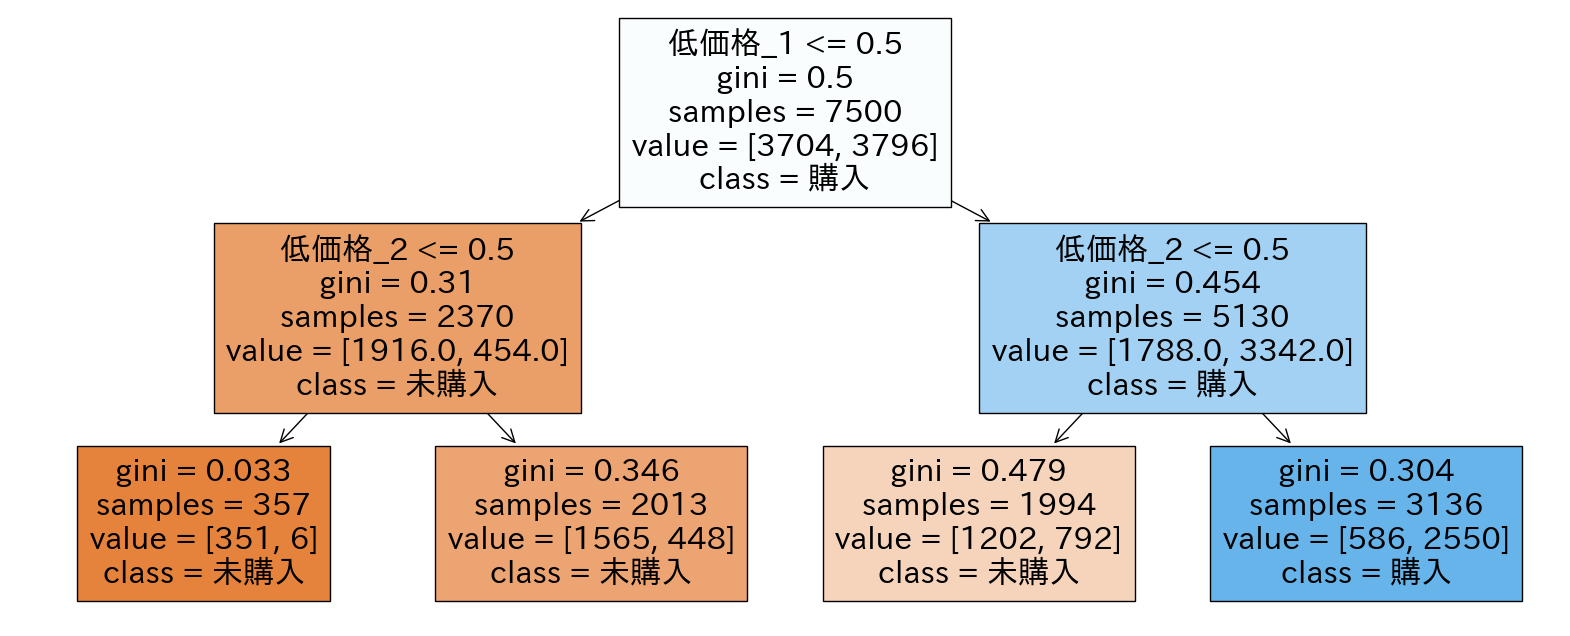

In [11]:
get_DT_result(df_first)

accuracy 0.7725118483412322


予測結果     
           未購入   購入
正解データ 未購入  531   91
      購入   197  447

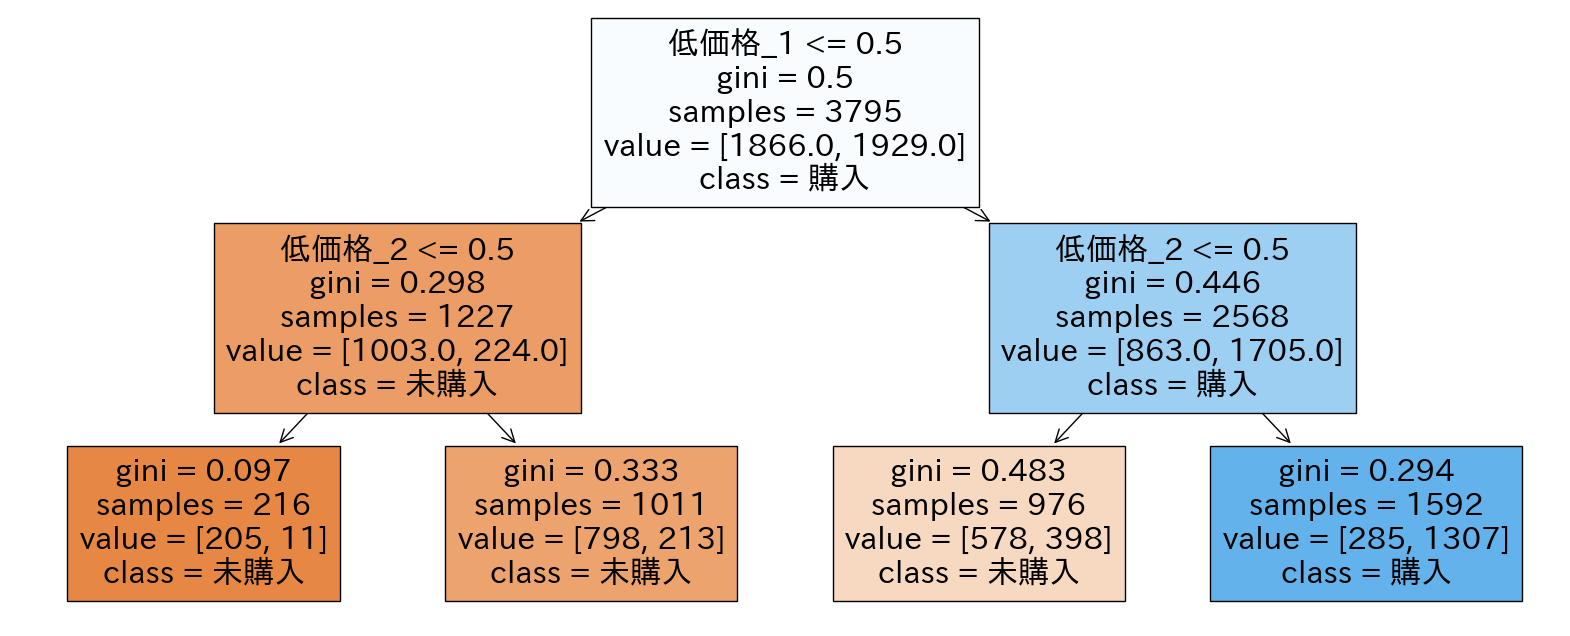

In [12]:
get_DT_result(df_second)


accuracy 0.7391304347826086


予測結果     
           未購入   購入
正解データ 未購入  274   57
      購入   111  202

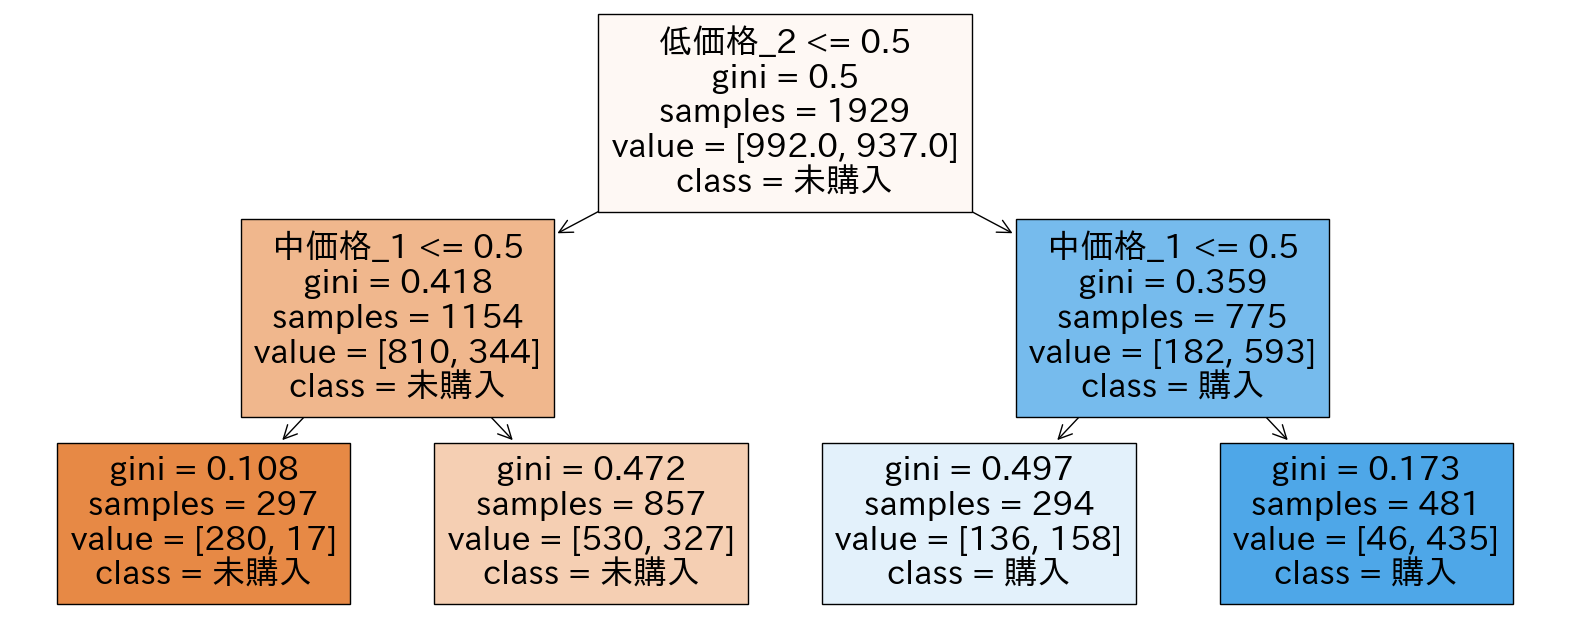

In [13]:
get_DT_result(df_third)

accuracy 0.7252396166134185


予測結果     
           未購入   購入
正解データ 未購入  119   38
      購入    48  108

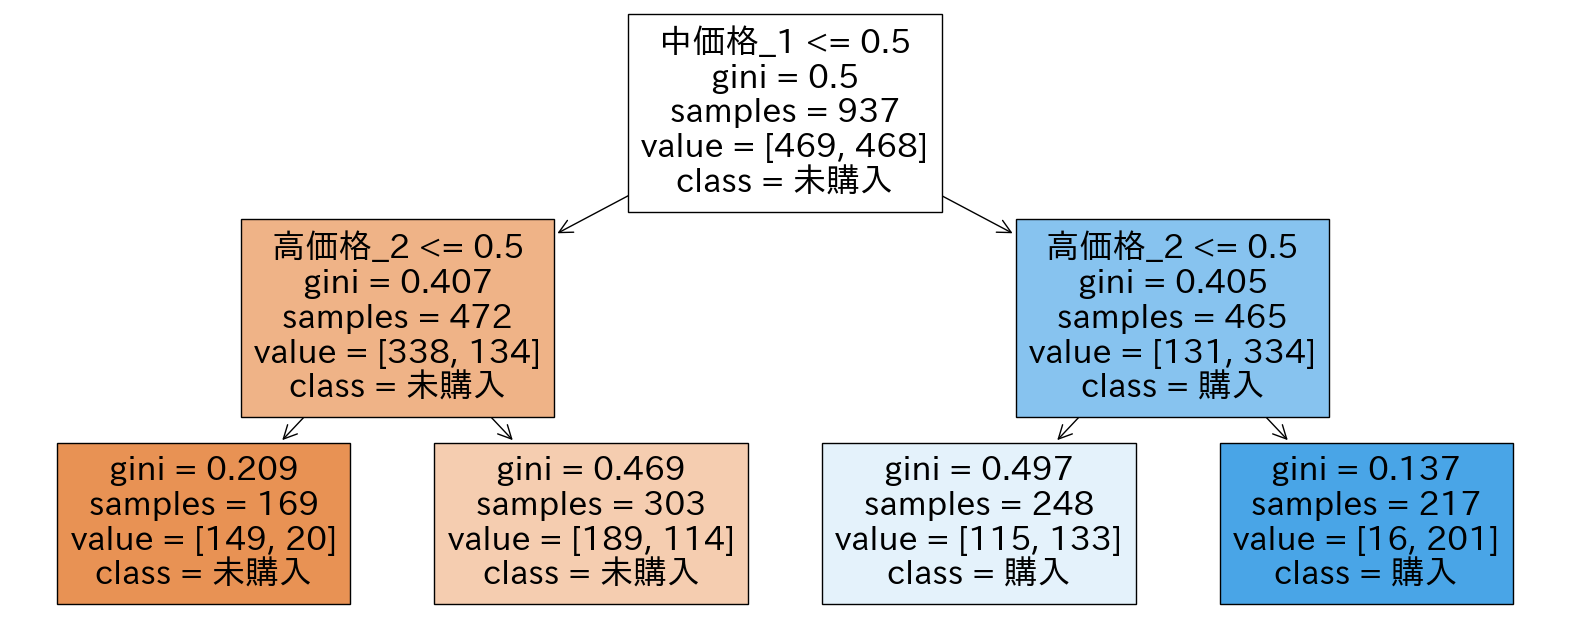

In [14]:
get_DT_result(df_4th)